## 03 - Volatility Regime Analysis  
In this notebook we classify the market into volatility regimes and visualize where motifs occur relative to these regimes.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import data_path

### Load processed BTCUSDT log return data

In [3]:
processed_files = sorted(data_path("processed").glob("*.parquet"))
if not processed_files:
    raise FileNotFoundError("No processed parquet files found. Run notebook 01 first.")
df = pd.read_parquet(processed_files[0])

### Recreate motif indices from Notebook 02
If motif indices are not already stored, recompute them using the same window and Matrix Profile configuration.

In [4]:
import stumpy
series = df["log_return"].dropna().to_numpy(dtype=float)
m = 60
mp = stumpy.stump(series, m)
profile = mp[:, 0].astype(float)
motif_idx = int(np.argmin(profile))
neighbor_idx = int(mp[motif_idx, 1])

### Compute rolling realized volatility and classify regimes

In [5]:
df["rolling_vol_60"] = df["log_return"].rolling(m).std()

low_thresh  = df["rolling_vol_60"].quantile(0.33)
high_thresh = df["rolling_vol_60"].quantile(0.66)

def classify_regime(vol):
    if vol < low_thresh:
        return "Low Vol"
    elif vol > high_thresh:
        return "High Vol"
    else:
        return "Normal"

df["vol_regime"] = df["rolling_vol_60"].apply(classify_regime)

### Visualize volatility regimes on price

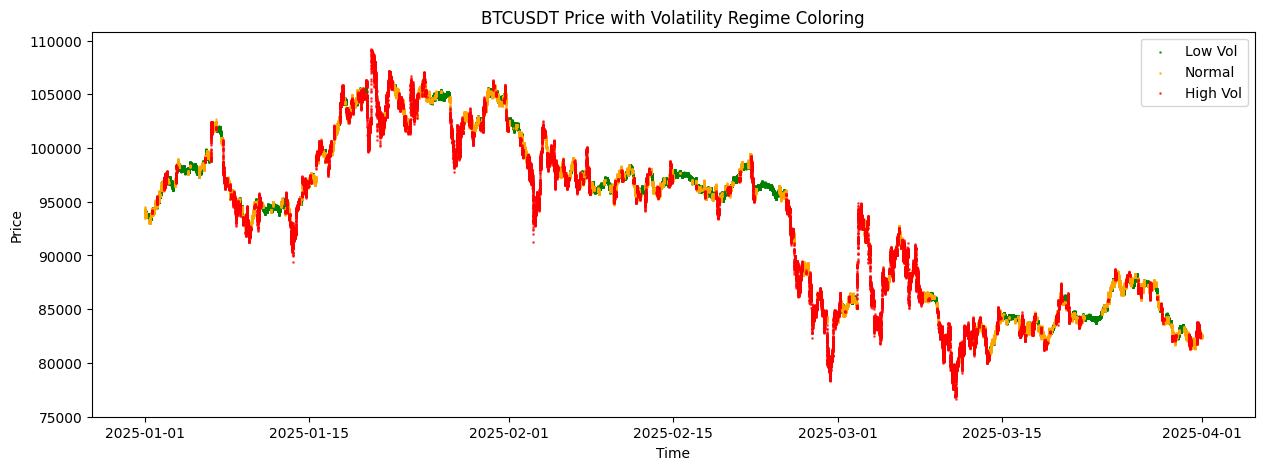

In [6]:
plt.figure(figsize=(15,5))
for regime, color in zip(["Low Vol","Normal","High Vol"], ["green","orange","red"]):
    subset = df[df["vol_regime"] == regime]
    plt.scatter(subset["open_time"], subset["close"], s=1, color=color, label=regime, alpha=0.6)

plt.title("BTCUSDT Price with Volatility Regime Coloring")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

### Overlay motif occurrences

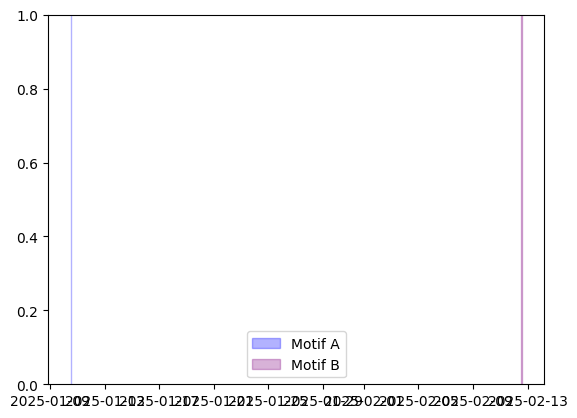

In [7]:
plt.axvspan(df.iloc[motif_idx]["open_time"], df.iloc[motif_idx + m]["open_time"], color="blue", alpha=0.3, label="Motif A")
plt.axvspan(df.iloc[neighbor_idx]["open_time"], df.iloc[neighbor_idx + m]["open_time"], color="purple", alpha=0.3, label="Motif B")
plt.legend()
plt.show()

### Display regime labels at motif timestamps

In [8]:
motif_time_a = df.iloc[motif_idx]["open_time"]
motif_time_b = df.iloc[neighbor_idx]["open_time"]
regime_a = df.iloc[motif_idx]["vol_regime"]
regime_b = df.iloc[neighbor_idx]["vol_regime"]

print(f"Motif A occurs at {motif_time_a} in regime: {regime_a}")
print(f"Motif B occurs at {motif_time_b} in regime: {regime_b}")

Motif A occurs at 2025-01-10 12:30:00+00:00 in regime: Normal
Motif B occurs at 2025-02-12 12:30:00+00:00 in regime: Low Vol


**Summary:**  
- We computed realized volatility with a rolling window of 60 minutes.  
- We classified volatility into three regimes based on quantiles: Low, Normal, High.  
- We visualized the BTCUSDT price colored by regime.  
- We overlaid motif occurrences to see in which regimes motifs occur.  
- We printed regimes at motif timestamps.